### The Universal Sentence Encoder
It is a powerful self-contained module capable of embedding words, phrases and sentences. It takes variable length input and outputs a 512-dimensional vector. The Transformer model's encoder part is considered.

#### Run the following to download the packages

In [0]:
import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

#### Run the following to load performance metrics


In [0]:
# pip install keras-metrics

In [3]:
### Required Libraries
import os, sys
import warnings
import keras_metrics
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk.collocations import *
from nltk.stem import WordNetLemmatizer

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


#### Load the Universal sentence encoder link

In [0]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/2" #@param ["https://tfhub.dev/google/universal-sentence-encoder/2", "https://tfhub.dev/google/universal-sentence-encoder-large/3"]
embed = hub.Module(module_url) # Import the Universal Sentence Encoder's TF Hub module
tf.logging.set_verbosity(tf.logging.ERROR) # Reduce logging output.
warnings.filterwarnings(action = 'ignore')

#### Load the dataset from the csv files
* Training : P1_training_set.csv
* Testing : P1_testing_set.csv


Create a collective dataset (df) - to perform pre-processing uniformly on the dataset

In [0]:
df_train_org = pd.read_csv("P1_training_set.csv")
df_train_shuf = shuffle(df_train_org)

df_test_org = pd.read_csv("P1_testing_set.csv")
df_test_shuf = shuffle(df_test_org)

frames = [df_train_shuf, df_test_shuf]
df = pd.concat(frames, axis=0)

### Preprocessing
* Word Tokenize : Convert the sentences into Tokens
* Use the stopwords and punctuation list from nltk to clean the word tokens
* Use WordNetLemmatizer to convert words to their base form
* From the word tokens produce the sentence

##### Note: Universal Encoder used here to embed sentences

In [0]:
def preprocessing(text):
    sent = ''.join(i for i in text if not i.isdigit())
    word_sent = word_tokenize(sent)
    _stopwords = set(stopwords.words('english') + list(punctuation))
    st = WordNetLemmatizer() 
    _stopwords.add("'s")
    word_sent = [st.lemmatize(word) for word in word_sent if word not in _stopwords]
    sentence = ' '.join(word for word in word_sent)
    return sentence

for i in df:
    df['process_E1'] = [preprocessing(i) for i in df['Event 1']]
    df['process_E2'] = [preprocessing(i) for i in df['Event 2']]    

### Sentence Embedding
Convert the sentences into vectors of len 512 using the "Universal Sentence Encoder"

In [0]:
sentences_embeddings_E1 = []
sentences_embeddings_E2 = []
with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  sentences_embeddings_E1 = session.run(embed(list(df['process_E1'])))
  sentences_embeddings_E2 = session.run(embed(list(df['process_E2'])))	
  
sent_list_E1 = list(sentences_embeddings_E1)
sent_list_E2 = list(sentences_embeddings_E2)  
sent_concat = list(map(lambda x, y: list(x) + list(y), sent_list_E1, sent_list_E2))

df_vec = pd.DataFrame(list(zip(sentences_embeddings_E1, sentences_embeddings_E2, sent_concat, df['Label'])),
                     columns = ['Sentence Embed 1', 'Sentence Embed 2', 'Collective Embed','Label'])

### Input and Output Dataset
* df_vec['Collective Embed'] - X : Input
* df_vec['Label'] - Y : Output

* Training : 70% of the Dataset
* Testing : 30% of the Dataset

In [0]:
X = df_vec['Collective Embed']
y = df_vec['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.30, random_state=42)					 
X_train = sequence.pad_sequences(X_train)
X_test = sequence.pad_sequences(X_test)

### Model 1
* Sequential Model
- 100 units - LSTM
- Dense Layer - 1 hidden unit with "sigmoid" activation function
- Dense Layer - 1 hidden unit with "softmax" activation function
- Optimizer - "rmsprop"

In [9]:
embedding_vecor_length = 32
model1 = Sequential()
model1.add(Embedding(10000, 500, input_length=1024))
model1.add(LSTM(100))
model1.add(Dense(1, activation='sigmoid'))
model1.add(Dense(1, activation="softmax"))
model1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

print(model1.summary())

# Training Phase - Fit the model
model1.fit(X_train, y_train, epochs=3, batch_size=64)

# Testing Phase - Evaluate the model
scores = model1.evaluate(X_test, y_test, verbose=0)

# Performance Metrics
print('Accuracy   : {:2.3}'.format(scores[1]))
print('Precision  : {:2.3}'.format(scores[2]))
print('Recall     : {:2.3}'.format(scores[3]))
print('Loss       : {:2.3}'.format(scores[0]))
f_score = (2.0 * scores[2] * scores[3]) / (scores[2] + scores[3])
print('F1-Score   : {:2.3}'.format(f_score))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1024, 500)         5000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               240400    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 5,240,503
Trainable params: 5,240,503
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
6276/6276 [==============================] - 187s 30ms/step - loss: -2.4310 - acc: 0.4039 - precision: 1.1525 - recall: 1.0000
Epoch 2/3
6276/6276 [==============================] - 187s 30ms/step - loss: -2.4310 - acc: 0.4039 

### Model 2
- Sequential Model
- 100 units - LSTM
- Dense Layer - 256 hidden unit with - "relu" activation function
- Dense Layer - 1 hidden unit with - - "softmax" activation function
- Optimizer - "adam"

In [10]:
embedding_vecor_length = 32
model2 = Sequential()
model2.add(Embedding(10000, 500, input_length=1024))
model2.add(LSTM(100))
model2.add(Dense(256, activation='relu'))
model2.add(Dense(1, activation="softmax"))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

print(model2.summary())
model2.fit(X_train, y_train, epochs=3, batch_size=64)

# Final evaluation of the model
scores = model2.evaluate(X_test, y_test, verbose=0)

print('Accuracy   : {:2.3}'.format(scores[1]))
print('Precision  : {:2.3}'.format(scores[2]))
print('Recall     : {:2.3}'.format(scores[3]))
print('Loss       : {:2.3}'.format(scores[0]))
f_score = (2.0 * scores[2] * scores[3]) / (scores[2] + scores[3])
print('F1-Score   : {:2.3}'.format(f_score))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 1024, 500)         5000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               240400    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               25856     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 5,266,513
Trainable params: 5,266,513
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
6276/6276 [==============================] - 186s 30ms/step - loss: -2.4310 - acc: 0.4039 - precision: 1.1525 - recall: 1.0000
Epoch 2/3
6276/6276 [==============================] - 187s 30ms/step - loss: -2.4310 - acc: 0.4039 

### Model 3
- RandomForestClassifier
- #Estimators - 200
- depth - 3
- random-state - 0

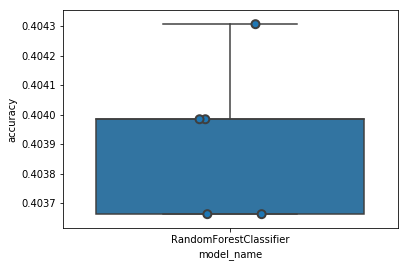

In [11]:
models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)]
CV = 5
cv_df = pd.DataFrame(index=range(len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [12]:
val = 0
for i in range(len(cv_df)):
  val  = val + cv_df['accuracy'][i]
val = val/5
print("---------------------")
print(cv_df['model_name'][i],'  Accuracy : {:2.3}%'.format(val* 100))
print('---------------------')

---------------------
RandomForestClassifier   Accuracy : 40.4%
---------------------


### Performance Measure
#### Google Colabs - GPU

#### Model 1 - Sequential - LSTM(100),Sigmod(1), Softmax(1)
* Accuracy   : 40.7%
* Precision  : 1.15
* Recall     : 1.0
* Loss       : -2.35
* F1-Score   : 1.07
##### Computation Time: 9.55 mins

#### Model 2 - Sequential - LSTM(100),Relu(256), Softmax(1)
* Accuracy   : 41%
* Precision  : 1.15
* Recall     : 1.0
* Loss       : -2.35
* F1-Score   : 1.07
##### Computation Time: 9.23 mins

#### Model 3 - Random Forest Classifier
* Accuracy : 40.4%